# **응급상황 자동 인식 및 응급실 연계 서비스**
# 단계2 : 파인튜닝!

## **0.미션**

### (1) 미션1
단계 2에서는 사전 학습된 한국어 BERT 모델을 다운받아, 파인튜닝을 시도합니다. 이를 위해 먼저 적절한 데이터를 수집해야 합니다.

* 학습 데이터 준비
    * 등급별 50개씩 샘플 데이터를 제공합니다.
    * **응급상황 등급(1~5) 별 최소 100건씩** 데이터를 추가로 수집(제작)하세요.
        * 중증도 카테고리 파일에 있는 키워드 참조
        * 제작시 GPT를 적극 활용해 봅시다.
    * 총 데이터 크기 : 600건
        * 제공데이터 100건(20건씩 5개 등급)
        * 추가 제작 500건(100건씩 5개 등급)

|text|label|
|----|----|
|GPT모델의 출력 형태. 응급상황 내용 | 응급등급(1~5)|



### (2) 미션2
미션1에서 준비한 학습데이터를 활용해서 파인튜닝을 시도합니다.

* 사용할 모델 : **klue/bert-base**
* 성능을 높이기 위해 조정할 만한 점(아래 수치는 가이드)
    - 데이터 양 늘리기
    - 하이퍼 파라미터
        - epoch 수 : 5 ~ 20
        - learning_rate : 1e-5 ~ 1e-2
        - batch_size : 16 ~ 32
        - weight_decay : 0.01 ~ 0.1

## 1.환경준비

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project6 폴더를 만들고,
        * 제공 받은 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 라이브러리 설치 및 로딩

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


* (필요 시) 설치 후 세션 다시 시작

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import load_dataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from warnings import filterwarnings
FutureWarning
filterwarnings('ignore')

* 함수 생성
    * evaluate : 모델 생성후, 데이터셋(예 : 검증셋)을 이용해서 모델 성능을 평가하기 위한 용도
    * predict :  하나의 문장을 입력받아, 예측결과를 반환

In [ ]:
# 검증셋 평가 함수
def evaluate(val_ds, model, device, tokenizer):
    # 입력 데이터셋 토크나이징 (attention_mask 포함)
    inputs = tokenizer(val_ds['text'], return_tensors="pt", padding=True,
                       truncation=True, max_length=128
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}  # 입력 텐서를 동일한 디바이스로 이동

    # 모델을 지정된 디바이스로 이동
    model = model.to(device)

    with torch.no_grad():  # 평가 과정에서 기울기 계산 비활성화
        outputs = model(**inputs)  # attention_mask를 포함해 입력

    # 예측 및 확률 계산
    probabilities = outputs.logits.softmax(dim=1)

    # probabilities가 GPU에 있을 경우에만 CPU로 이동
    if probabilities.is_cuda:
        probabilities = probabilities.cpu().detach().numpy()
    else:
        probabilities = probabilities.detach().numpy()

    pred = np.argmax(probabilities, axis=1)

    # GPU 메모리에서 필요 없는 텐서 제거 및 캐시 정리
    del inputs
    torch.cuda.empty_cache()

    return pred, probabilities

In [ ]:
# 데이터 예측 함수
def predict(text, model, tokenizer):
    # 입력 문장 토크나이징
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {key: value for key, value in inputs.items()}  # 각 텐서를 GPU로 이동

    # 모델 예측
    with torch.no_grad():
        outputs = model(**inputs)

    # 로짓을 소프트맥스로 변환하여 확률 계산
    logits = outputs.logits
    probabilities = logits.softmax(dim=1)

    # 가장 높은 확률을 가진 클래스 선택
    pred = torch.argmax(probabilities, dim=-1).item()

    return pred, probabilities

### (2) 구글드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/project6_2/'

### (3) 데이터 로딩
* 이전 미션에서 준비한 데이터셋을 로딩합니다.

In [ ]:
dataset = pd.read_csv(path+"dataset.csv")

In [ ]:
dataset

,text,label
0,"교통사고, 두개골 골절, 의식 흐림",1
1,"익사, 구조, 호흡 중단, 맥박 약함",1
2,"벌 쏘임, 알레르기 반응, 목 붓기, 호흡 중단",1
3,"고열, 탈수, 의식 상실, 움직임 불가",1
4,"전기 감전, 심정지, 피부 화상",1
...,...,...
1995,발톱 깨짐으로 경미한 따가움,5
1996,손톱 긁힘으로 경미한 통증,5
1997,발톱 긁힘으로 경미한 불편함,5
1998,손등 긁힘으로 경미한 불편함,5


* y 분포 확인하기

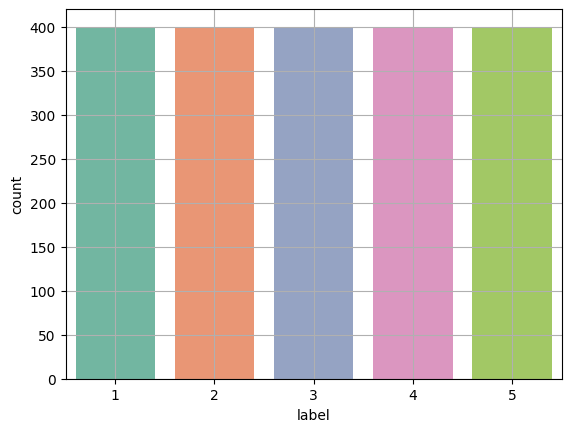

In [ ]:
sns.countplot(x='label', data = dataset, palette='Set2')
plt.grid()
plt.show()

* label 에 대한 정수 인코딩
    * 정수 인코딩은 0 부터 시작해야 함.

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataset['label'] = le.fit_transform(dataset['label'])
dataset.head()

,text,label
0,"교통사고, 두개골 골절, 의식 흐림",0
1,"익사, 구조, 호흡 중단, 맥박 약함",0
2,"벌 쏘임, 알레르기 반응, 목 붓기, 호흡 중단",0
3,"고열, 탈수, 의식 상실, 움직임 불가",0
4,"전기 감전, 심정지, 피부 화상",0


### (4) GPU 설정
* 파이토치를 위한 설정

In [ ]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2.데이터 준비

### (1) Dataset 만들기 : train, val

In [ ]:
# 데이터셋 분할
train, val = train_test_split(dataset, test_size=0.2, random_state=42)

In [ ]:
# 텐서 데이터셋으로 변환
train_ds = Dataset.from_pandas(train)
val_ds = Dataset.from_pandas(val)

### (2) 토큰화

* 사용할 모델("klue/bert-base")의 토크나이저를 저장

In [ ]:
# 모델과 토크나이저 불러오기
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# 토큰화 함수 생성 및 적용

def preprocess_function(data):
    return tokenizer(data['text'], truncation=True, padding=True)

train_ds = train_ds.map(preprocess_function, batched=True)
val_ds = val_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

## 3.Fine-Tuning

### (1) 사전학습 모델 준비
* 사용할 모델("klue/bert-base")의 토크나이저를 저장
* 이때, 출력층 노드 수를 지정합니다.

In [ ]:
# 모델 설정 (다중 분류를 위해 num_labels 지정)
n = 5
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = n).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### (2) 학습
* 절차
    * TrainArguments 설정
        * 조정할 하이퍼파라미터 : learning_rate, batch_size, epochs, weight_decay 등
        * 나머지 옵션은 손 대지 맙시다.
    * Trainer 설정
    * 학습
* 성능 : 데이터, 하이퍼파라미터에 의해 결정

In [ ]:
# TrainingArguments

lr = 2e-5
batch_size = 16
epochs = 20

training_args = TrainingArguments(
    output_dir = './results',          # 출력 디렉토리
    eval_strategy = "epoch",            # 에폭마다 평가
    save_strategy = "epoch",           # 에폭마다 체크포인트 저장
    learning_rate = lr,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs  = epochs,
    weight_decay = 0.01,               # <--[조정가능]weight decay
    load_best_model_at_end = True,     # 가장 좋은 모델을 마지막에 로드
    logging_dir ='./logs',            # 로깅 디렉토리
    logging_steps = 10,                # 로깅 스텝
    report_to="tensorboard"          # TensorBoard에 로깅
)

In [ ]:
# Trainer 설정
patience = 10

trainer = Trainer(
    model=model,                         # 학습할 모델
    args=training_args,                  # TrainingArguments
    train_dataset = train_ds,
    eval_dataset = val_ds,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=patience)], # 조기 종료
)

In [ ]:
# 모델 학습

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.133200,0.289379
2,0.209000,0.241491
3,0.091200,0.284173
4,0.060000,0.288077
5,0.057800,0.275221
6,0.077400,0.269385
7,0.038200,0.243057
8,0.143400,0.370804
9,0.018800,0.329887
10,0.045100,0.300278


TrainOutput(global_step=1200, training_loss=0.06473429379519074, metrics={'train_runtime': 253.4718, 'train_samples_per_second': 126.247, 'train_steps_per_second': 7.89, 'total_flos': 243421867584000.0, 'train_loss': 0.06473429379519074, 'epoch': 12.0})

In [ ]:
# 모델 평가

eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.24149055778980255, 'eval_runtime': 0.5704, 'eval_samples_per_second': 701.211, 'eval_steps_per_second': 43.826, 'epoch': 12.0}


### (3) 모델 검증평가
* evaluate 함수를 이용해서 검증셋에 대한 성능 평가를 수행합니다.

### (4) 모델 사용
* 응급상황에 대한 샘플 문자을 넣고 등급을 적절히 분류하는지 눈으로 확인해 봅시다.

## 4.모델 저장

### (1) 모델 저장
* save_pretrained 메서드를 사용해 모델과 토크나이저를 디렉토리에 저장합니다.
* 저장 대상 : 모델, 토크나이저

In [ ]:
# 모델과 토크나이저 저장 경로 : 폴더가 없으면, fine_tuned_bert를 생성
save_directory = path + "fine_tuned_bert"

# 모델 저장
model.save_pretrained(save_directory)

# 토크나이저도 함께 저장
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/project6_2/fine_tuned_bert/tokenizer_config.json',
 '/content/drive/MyDrive/project6_2/fine_tuned_bert/special_tokens_map.json',
 '/content/drive/MyDrive/project6_2/fine_tuned_bert/vocab.txt',
 '/content/drive/MyDrive/project6_2/fine_tuned_bert/added_tokens.json',
 '/content/drive/MyDrive/project6_2/fine_tuned_bert/tokenizer.json')

### (2) 모델 로딩 및 사용
* 저장한 모델을 나중에 다시 불러와 예측이나 추가 작업에 사용할 수 있습니다. Hugging Face from_pretrained 메서드를 사용하여 저장 경로에서 모델과 토크나이저를 로드합니다.
* 로딩 대상 : 모델, 토크나이저

In [ ]:
# 모델 로드
model2 = AutoModelForSequenceClassification.from_pretrained(save_directory)

# 토크나이저 로드
tokenizer2 = AutoTokenizer.from_pretrained(save_directory)

In [ ]:
text = "교통사고, 의식 흐림"
predicted_class, probabilities = predict(text, model2, tokenizer2)

print(f"예측된 클래스: {predicted_class}")
print(f"예측된 클래스 이름: {predicted_class+1}등급")
print(f"클래스별 확률: {probabilities}")

예측된 클래스: 0
예측된 클래스 이름: 1등급
클래스별 확률: tensor([[9.9824e-01, 4.7714e-04, 4.6561e-04, 5.2398e-04, 2.8901e-04]])


## **Mission Complete!**

수고 많았습니다!

In [ ]:
long_emergency_cases  = """
교통사고, 두개골 골절, 의식 흐림
익사, 구조, 호흡 중단, 맥박 약함
벌 쏘임, 알레르기 반응, 목 붓기, 호흡 중단
고열, 탈수, 의식 상실, 움직임 불가
전기 감전, 심정지, 피부 화상
낙상, 다리 골절, 출혈 지속
화재, 연기 흡입, 폐 손상, 호흡 정지
독성 약물 섭취, 구토, 호흡 곤란
추락, 머리 부상, 생명 위급
급성 심부전, 심정지, 응급 처치 필요
교통사고, 팔 골절, 심각한 출혈
외부 충격, 폐 손상, 호흡 어려움
독성 가스 흡입, 목 붓기, 의식 흐림
급성 알레르기 반응, 두드러기, 호흡 곤란
화학물질 화상, 피부 손상, 통증
교통사고, 갈비뼈 골절, 폐 손상, 호흡 곤란
낙상, 척추 골절, 골반 골절, 통증
경련 발작, 의식 상실, 전신 떨림
독성 물질 섭취, 복통, 구토, 의식 흐림
물에 빠짐, 저체온증, 폐 손상
급성 심장 이상, 쓰러짐, 맥박 약함
화재, 전신 화상, 피부 손상
약물 과다 복용, 호흡 중단
낙상, 두개골 손상, 뇌출혈
교통사고, 다리 손상, 심각한 통증
화재, 얼굴 화상, 목 화상
벌 쏘임, 알레르기 반응, 숨 막힘
교통사고, 폐 손상, 심장 손상, 호흡 곤란
고열, 심각한 탈수, 의식 상실
추락, 골반 골절, 움직임 불가
전신 경련, 몸 떨림, 의식 상실
독성 약물 중독, 구토, 호흡 곤란
교통사고, 갈비뼈 골절, 폐 손상
화학물질 노출, 피부 손상, 호흡 곤란
독성 가스 흡입, 기도 폐쇄, 호흡 곤란
물에 빠짐, 심폐소생술 필요
교통사고, 머리 손상, 출혈 지속, 의식 없음
화재, 연기 흡입, 호흡 어려움
독성 약물 섭취, 구토, 의식 흐림
심근경색, 가슴 통증, 쓰러짐
물에 빠짐, 저체온증, 움직임 불가
독성 물질 흡입, 목 붓기, 호흡 불가
화재, 화상, 고통
낙상, 척추 골절, 복합 골절
교통사고, 다리 절단, 심한 출혈
독성 가스 흡입, 호흡 중단, 의식 없음
전기 사고, 심정지
교통사고, 폐 손상, 통증
급성 심장 이상, 맥박 약함
전신 화상, 피부 손상
낙상, 골반 골절, 의식 흐림
전기 감전, 화상, 쓰러짐
교통사고, 머리 부상, 출혈 지속
익사, 심폐소생술 필요, 의식 없음
독성 물질 섭취, 구토, 혼란, 의식 없음
화학물질 노출, 피부 손상, 눈 손상
낙상, 척추 손상, 다리 감각 없음
교통사고, 갈비뼈 골절, 폐 손상
심장 이상, 심정지
물에 빠짐, 호흡 중단, 맥박 약함
화재, 전신 화상, 통증
교통사고, 다리 절단, 출혈 지속
경련 발작, 의식 상실, 몸 떨림
독성 약물 중독, 호흡 어려움
화학물질 노출, 피부 손상, 호흡 막힘
익사, 구조, 심폐소생술 필요
교통사고, 머리 부상, 출혈 지속
심근경색, 쓰러짐, 심폐소생술 필요
낙상, 골반 골절
벌 쏘임, 알레르기 반응, 호흡 곤란
교통사고, 척추 골절, 갈비뼈 골절
전기 감전, 심장 정지
화재, 연기 흡입, 호흡 정지
독성 약물 섭취, 혼수 상태
낙상, 두개골 손상, 뇌출혈
독성 가스 흡입, 호흡 정지
화재, 전신 화상, 통증
교통사고, 다리 손상, 심한 출혈
낙상, 척추 손상, 두개골 손상
급성 심부전, 호흡 중단
화학물질 노출, 눈 손상, 피부 손상
독성 약물 섭취, 구토, 호흡 곤란
교통사고, 폐 손상, 갈비뼈 골절
심한 알레르기 반응, 호흡 정지
화재, 머리 부상, 출혈, 의식 상실
낙상, 골반 골절, 움직임 불가
교통사고, 폐 손상, 생명 위급
화학물질 노출, 시력 손실, 호흡 곤란
독성 약물 섭취, 호흡 중단, 구토
물에 빠짐, 저체온증
고속 충돌, 머리 부상, 뇌출혈
알레르기 반응, 피부 부기, 호흡 곤란
교통사고, 다리 골절, 심각한 출혈
벌 쏘임, 붓기, 호흡 곤란
높은 곳 추락, 척추 손상
심근경색, 의식 상실, 쓰러짐
물에 빠짐, 심폐소생술 필요
화학물질 노출, 호흡 곤란, 피부 손상
전기 사고, 의식 상실, 경직
교통사고, 절단, 출혈 지속
화재, 전신 화상, 피부 손상
물에 빠짐, 호흡 중단, 의식 없음
심근경색, 가슴 통증, 의식 상실
벌 쏘임, 목 붓기, 숨 막힘
심정지, 맥박 중단, 호흡 중단
독성 가스 흡입, 호흡 중단, 입술 청색증
높은 곳 추락, 척추 손상, 움직임 불가
경련 발작, 의식 상실, 몸 떨림
전기 감전, 의식 상실, 경직
교통사고, 머리 부상, 출혈 지속
복부 외상, 복통, 출혈, 움직임 불가
급성 폐렴, 호흡 곤란
전신 경련, 의식 상실
물에 빠짐, 저체온증, 의식 흐림
약물 과다 복용, 의식 혼미, 창백한 피부
화학물질 노출, 피부 손상, 호흡 곤란
뇌출혈, 의식 상실, 반응 없음
낙상, 갈비뼈 골절, 호흡 고통
심장마비, 쓰러짐, 맥박 약화
교통사고, 팔 골절, 출혈 지속
전신 알레르기 반응, 피부 부기, 호흡 곤란
독성 물질 섭취, 구토, 복통, 의식 혼미
낙상, 두개골 부상, 출혈 지속
교통사고, 갈비뼈 골절, 폐 손상
심부전, 호흡 중단, 의식 없음
화상, 피부 손상, 고통
약물 과다 복용, 경련, 의식 상실
교통사고, 다리 손상, 심한 출혈
익사 위험, 호흡 중단, 피부 청색증
고열, 탈진, 의식 상실
복부 출혈, 창백한 얼굴, 맥박 약화
기도 폐쇄, 숨 막힘, 입술 청색증
낙상, 골반 골절, 움직임 불가
머리 부상, 뇌출혈, 의식 상실
벌 쏘임, 붓기, 호흡 곤란
독성 약물 섭취, 의식 혼미, 맥박 약화
화학물질 노출, 눈 손상, 피부 손상
물에 빠짐, 저체온증, 호흡 정지
교통사고, 척추 손상, 사지 마비
전기 감전, 화상, 신체 손상
심장 이상, 가슴 통증, 혼란
익사, 심폐소생술 필요, 호흡 중단
외부 충격, 갈비뼈 골절, 폐 손상
낙상, 손목 골절, 무릎 골절
화재 사고, 화학물질 노출, 호흡 곤란
머리 부상, 경련, 구토
알레르기 반응, 목 붓기, 의식 흐림
교통사고, 차량 갇힘, 출혈 지속
독성 가스 흡입, 숨 막힘, 생명 위급
화재, 연기 흡입, 호흡 정지
독성 물질 섭취, 복통, 경련
물에 빠짐, 폐 손상, 의식 없음
쇼크, 혈압 저하, 의식 상실
교통사고, 갈비뼈 골절, 호흡 곤란
낙상, 복합 골절, 통증
알레르기 반응, 목 붓기, 숨 막힘
물속 구조, 심폐소생술 필요
전신 화상, 피부 손상
독성 가스 흡입, 기도 폐쇄, 호흡 곤란
대형 사고, 의식 없음, 움직임 불가
약물 과다 복용, 호흡 중단
독성 물질 노출, 피부 손상, 호흡 곤란
고속 충격, 골절, 출혈
고온 기계 접촉, 화상
심근경색, 가슴 통증, 의식 상실
높은 곳 추락, 척추 손상
독성 물질 섭취, 호흡 중단
물속 체류, 저체온증
교통사고, 머리 출혈, 의식 없음
경련 발작, 몸 떨림, 의식 상실
화재, 숨 막힘, 피부 손상
익사, 폐 손상
벌레 물림, 두드러기, 호흡 곤란
심장 이상, 심폐소생술 필요
교통사고, 다리 절단, 대량 출혈
화학물질 흡입, 의식 상실, 호흡 중단
약물 과다 복용, 급성 중독
독성 약물 복용, 복통, 구토
교통사고, 척추 손상, 생명 위급
전기 감전, 화상, 의식 상실
물에 빠짐, 폐 손상, 호흡 정지
독성 가스 흡입, 기도 막힘, 의식 없음
교통사고, 가슴뼈 골절, 통증
익사, 의식 없음, 맥박 약함
교통사고, 머리 부상, 출혈 지속
화재, 전신 화상, 의식 상실
익사 위기, 호흡 중단, 맥박 약함
전기 감전, 심정지, 피부 화상
교통사고, 갈비뼈 골절, 폐 손상
화학물질 흡입, 호흡 정지, 피부 손상
독성 가스 흡입, 기도 막힘, 의식 없음
낙상, 척추 손상, 마비
화학물질 노출, 시력 손상, 호흡 곤란
독성 약물 섭취, 복통, 구토
심근경색, 심폐소생술 필요
고열, 의식 상실, 탈진
호흡곤란, 청색증, 위급
의식 상실, 반응 없음
혈압 저하, 쇼크
호흡 정지, 위급
숨 막힘, 가슴 통증
무의식, 근육 긴장 없음
호흡곤란, 산소 공급 필요
맥박 약화, 혈압 저하, 쓰러짐
경련, 의식 상실
산소 포화도 저하, 혼란
혈압 미측정, 저혈압
의식 없음, 동공 반응 없음
호흡 정지, 위급
출혈, 피부 창백
반응 없음, 호흡 불규칙
맥박 미약
의식 없음, 근육 경련 지속
천명음, 호흡곤란
저혈압, 쓰러짐
얼굴 청색증, 숨 막힘
혈액 순환 중단 위험
근육 경직, 의식 없음
호흡 정지 우려
심각한 쇼크, 저혈압
동공 확대, 의식 없음
호흡곤란, 말 불가
혈압 저하, 맥박 느림
의식 소실, 반응 없음
흉통, 호흡곤란
급성 알레르기 반응, 기도 폐쇄
두통, 구토, 의식 소실
호흡 불규칙, 어려움
위급, 혈압 미측정
반응 없음, 경련
피부색 변화, 숨 막힘
혈액 손실, 쇼크
심각한 호흡곤란, 호흡 보조 필요
맥박 느림, 저혈압
주변 자극 반응 없음
패혈증, 혈압 저하
맥박 불규칙, 의식 흐림
청색증, 호흡 곤란
두드러기, 호흡곤란
반응 없음, 눈 감음
호흡 약화, 불규칙
출혈, 의식 상실
맥박 저하, 저혈압
탈수, 의식 흐림
호흡 정지
쇼크, 매우 낮은 혈압
근육 이완, 반응 없음
호흡곤란, 숨 막힘
맥박 미측정
경련, 의식 없음
얼굴 청색증, 숨 막힘
복통, 쇼크
동공 확대, 반응 없음
산소 부족, 심각한 호흡곤란
혈압 저하, 맥박 약함
의식 소실, 주변 반응 없음
심근경색, 흉통, 호흡곤란
뇌출혈, 의식 없음
호흡 불규칙
출혈, 혈압 저하
반응 없음, 의식 없음
호흡 정지, 위급
저혈압, 쓰러짐
눈 뜨지 않음, 반응 없음
호흡 약화, 산소 공급 필요
출혈, 쇼크
맥박 불규칙, 의식 흐림
의식 소실, 움직이지 않음
알레르기 반응, 얼굴 붓기
저혈압, 맥박 느림
근육 긴장 없음, 반응 없음
호흡곤란, 헐떡임
혈압 미측정, 매우 낮음
동공 반응 없음, 의식 없음
숨 막힘, 위급
출혈, 의식 상실
뇌졸중, 의식 흐림
눈 뜨지 않음, 의식 소실
호흡 불규칙
쇼크, 매우 낮은 혈압
반응 없음, 경련
복통, 의식 소실
혈액 순환 중단 위험
근육 경직, 의식 없음
심각한 호흡곤란, 움직임 불가
저혈압, 맥박 느림
의식 소실, 주변 반응 없음
호흡 어려움, 산소 마스크 필요
전기 화상, 의식 없음
맥박 약화, 의식 흐림
동공 반응 없음, 의식 없음
화학물질 흡입, 호흡곤란
저혈압, 쓰러짐
반응 없음, 눈 감음
독극물 중독, 의식 없음
호흡 부전, 호흡 어려움
저체온증, 의식 없음
저혈압, 맥박 약함
의식 소실, 주변 자극 반응 없음
감염, 의식 흐림
호흡 불규칙, 어려움
출혈, 혈압 저하
의식 없음, 반응 없음
뇌 손상, 의식 없음
저혈압, 쓰러짐
눈 뜨지 않음, 반응 없음
호흡 약화, 산소 공급 필요
쇼크, 피부 차가움
맥박 불규칙, 의식 흐림
의식 소실, 움직이지 않음
고열, 의식 흐림
저혈압, 맥박 느림
근육 긴장 없음, 반응 없음
호흡곤란, 숨 헐떡임
저혈압, 매우 낮음
동공 반응 없음, 의식 없음
저혈당, 의식 상실
출혈, 의식 상실
맥박 약화, 저혈압
눈 뜨지 않음, 의식 소실
호흡 불규칙
쇼크, 매우 낮은 혈압
반응 없음, 경련
탈수, 의식 흐림
혈액 순환 중단 위험
근육 경직, 의식 없음
호흡곤란, 움직임 불가
저혈압, 맥박 느림
의식 소실, 주변 반응 없음
감전, 의식 없음
산소 마스크 필요, 호흡 어려움
패혈증, 혈압 저하
맥박 불규칙, 의식 흐림
동공 반응 없음, 의식 없음
약물 과다 복용, 의식 없음
저혈압, 쓰러짐
반응 없음, 눈 감음
외상, 쇼크
맥박 느림, 혈압 저하
움직이지 않음, 의식 소실
과호흡, 의식 흐림
위급, 혈압 미측정
근육 이완, 반응 없음
호흡곤란, 숨 막힘
맥박 미측정
경련, 의식 없음
얼굴 청색증, 숨 막힘
복통, 쇼크
동공 확대, 반응 없음
산소 부족, 심각한 호흡곤란
혈압 저하, 맥박 약함
의식 소실, 주변 반응 없음
심근경색, 흉통, 호흡곤란
뇌출혈, 의식 없음
호흡 불규칙
출혈, 혈압 저하
반응 없음, 의식 없음
호흡 정지, 위급
저혈압, 쓰러짐
눈 뜨지 않음, 반응 없음
호흡 약화, 산소 공급 필요
출혈, 쇼크
맥박 불규칙, 의식 흐림
의식 소실, 움직이지 않음
알레르기 반응, 얼굴 붓기
저혈압, 맥박 느림
근육 긴장 없음, 반응 없음
호흡곤란, 숨 헐떡임
혈압 미측정, 매우 낮음
동공 반응 없음, 의식 없음
숨 막힘, 위급
출혈, 의식 상실
뇌졸중, 의식 흐림
눈 뜨지 않음, 의식 소실
호흡 불규칙
쇼크, 매우 낮은 혈압
반응 없음, 경련
복부 통증, 의식 소실
혈액 순환 중단 위험
근육 경직, 의식 없음
호흡곤란, 움직임 불가
저혈압, 맥박 느림
의식 소실, 주변 반응 없음
산소 마스크 필요, 호흡 어려움
전기 화상, 의식 없음
맥박 약화, 의식 흐림
동공 반응 없음, 의식 없음
화학물질 흡입, 호흡곤란
저혈압, 쓰러짐
반응 없음, 눈 감음
독극물 중독, 의식 없음
호흡 부전, 호흡 어려움
저체온증, 의식 없음
저혈압, 맥박 약함
의식 소실, 주변 자극 반응 없음
감염, 의식 흐림
호흡 불규칙, 어려움
출혈, 혈압 저하
의식 없음, 반응 없음
뇌 손상, 의식 없음
"""

cases_list = [case.strip() for case in long_emergency_cases.split("\n") if case.strip()]

# Create a DataFrame
df_cases = pd.DataFrame(cases_list, columns=["text"])
df_cases['label'] = 1

# Save to CSV
file_path_full = path + "full_emergency_cases_1.csv"
df_cases.to_csv(file_path_full, index=False)

file_path_full

'/content/drive/MyDrive/project6_2/full_emergency_cases_1.csv'

In [ ]:
long_emergency_cases  = """
도주 가능성, 타인 안전 위협
패혈증, 고열, 빠른 호흡, 혼란
발작 후, 초조, 불안
극심한 불안, 초조, 경계
면역억제, 감염 위험, 열
호흡곤란, 빠른 호흡, 혼란
혈압 저하, 맥박 빠름, 혈역학적 이상
의식 흐릿함, 주변 인지 어려움
고열, 감염 위험, 면역력 저하
혼란, 발작 후 피로
산소포화도 저하, 호흡곤란
반복적 호흡곤란, 산소 치료 필요
혼란, 주변 상황 인지 어려움
타인 위협 가능성, 흥분 상태
혈압 저하, 졸음, 혼란
도주 위험, 의료진 접근 방해
중등도 호흡곤란, 산소 부족
패혈증 의심, 고열, 혼란
반복적 혼란 행동, 타인 위협
산소 부족, 치료 필요
불안, 심박수 상승
발작 후 피로, 움직임 제한
타인 안전 위협, 도주 가능성
빠른 맥박, 의식 저하
도주 위험, 사고 반복 가능성
면역억제 상태, 감염 취약
반복적 호흡곤란, 산소포화도 감소
패혈증, 고열, 빠른 심박수
도주 위험, 위험 행동
의식 흐릿함, 혈압 저하
발작 후 혼란, 초조
도주 위험, 타인 위협
면역력 저하, 감염 취약
호흡곤란, 산소 공급 필요
혼란, 반복적 행동
불안, 의료진 비협조
산소포화도 감소, 치료 필요
혈압 저하, 심혈관 우려
발작 후 극심한 피로
도주 위험, 치료 거부
고열, 빠른 심박수, 혼란
의식 혼미, 혈압 불안정
반복적 발작, 움직임 제한
타인 위협, 흥분 행동
면역억제 상태, 열
도주 가능성, 의료진 방해
반복적 호흡곤란, 치료 필요
혼란, 치료 비협조
발작 후 혼란, 피로
중등도 호흡곤란, 산소 부족
혈압 저하, 빠른 맥박
타인 위협 가능성, 도주 위험
의식 희미, 치료 거부
패혈증, 의식 혼탁, 고열
반복적 초조, 치료 방해
면역 억제, 감염 우려
도주 가능성, 타인 위협 행동
빠른 심박수, 혈압 저하
도주 위험, 사고 유발 가능성
패혈증, 고열, 빠른 호흡
반복적 행동, 혼란
의식 흐릿, 치료 비협조
발작 후 초조, 피로
산소 치료 필요, 호흡곤란
의식 저하, 혼란 상태
의료진 접근 방해, 도주 위험
타인 안전 위협 가능성, 치료 거부
패혈증, 고열, 혼란
발작 후 혼란, 피로
반복적 치료 거부, 혼란
호흡곤란, 산소 부족 증상
의식 혼탁, 혈압 불안정
도주 위험, 의료진 비협조
패혈증 의심, 빠른 심박수
도주 위험, 타인 위협 행동
발작 후 초조, 불안
고열, 면역억제, 감염 우려
호흡곤란, 산소 치료 필수
혼란, 의식 저하, 치료 방해
혈압 저하, 빠른 심박수
의식 흐릿, 치료 협조 어려움
타인 위협 가능성, 불안
반복적 발작, 혼란
도주 가능성, 사고 위험
의식 혼미, 치료 거부
중등도 호흡곤란, 산소 부족
패혈증 가능성, 고열, 혼란
타인 위협 가능성, 치료 거부
발작 후 혼란, 피로
빠른 심박수, 혈압 저하
도주 위험, 의료진 접근 방해
패혈증, 고열, 빠른 호흡
의식 저하, 혼란 상태
호흡곤란, 산소 부족 증상
면역력 저하, 감염 위험
반복적 초조, 치료 방해
의식 흐릿, 치료 협조 어려움
발작 후 피로, 치료 비협조
혼란 상태, 도주 위험
패혈증, 혼란, 치료 필요
도주 가능성, 타인 안전 위협
발작 후, 혼란, 움직임 제한
패혈증, 고열, 의식 혼탁
반복적 호흡곤란, 산소 치료 필요
의식 흐릿함, 주변 인지 어려움
빠른 심박수, 혈압 저하
타인 위협 가능성, 불안
면역 억제, 감염 위험
호흡곤란, 산소포화도 감소
반복적 초조, 치료 거부
발작 후 피로, 혼란
혈압 불안정, 치료 필요
의료진 접근 방해, 도주 위험
타인 위협 행동, 도주 가능성
패혈증, 고열, 혼란 상태
산소 부족, 치료 필수
중등도 호흡곤란, 빠른 호흡
반복적 발작, 혼란
의식 저하, 치료 비협조
패혈증, 고열, 빠른 맥박
혼란 상태, 치료 거부
타인 위협 가능성, 의료진 비협조
발작 후 초조, 불안
의식 흐릿함, 혈압 저하
호흡곤란, 산소 치료 필수
의식 혼미, 치료 거부
도주 가능성, 타인 위협 행동
패혈증 의심, 빠른 심박수
면역억제, 감염 위험
중등도 호흡곤란, 산소포화도 감소
반복적 치료 거부, 혼란
혈압 저하, 빠른 맥박
타인 안전 위협, 도주 가능성
혼란, 반복적 초조 행동
의식 저하, 혈압 불안정
패혈증, 고열, 혼란
반복적 발작, 치료 필요
도주 위험, 사고 유발 가능성
의료진 방해, 타인 위협
산소 부족, 호흡곤란
의식 흐릿함, 치료 비협조
패혈증 의심, 고열, 빠른 호흡
타인 위협 가능성, 흥분 상태
반복적 행동, 초조
의식 저하, 치료 필요
발작 후 극도의 피로
도주 가능성, 위험 행동
혼란, 치료 거부
중등도 호흡곤란, 산소포화도 저하
면역력 저하, 감염 취약
타인 안전 위협 가능성
혈압 저하, 혼란 상태
패혈증 의심, 빠른 심박수, 고열
발작 후 혼란, 움직임 제한
의식 혼미, 치료 방해
산소 부족, 호흡곤란
반복적 초조, 치료 비협조
의식 흐릿함, 혼란 상태
도주 가능성, 의료진 방해
패혈증, 고열, 빠른 호흡
타인 위협 가능성, 불안 상태
의식 저하, 치료 필요
반복적 호흡곤란, 산소 치료 필수
혈압 저하, 빠른 맥박
면역억제 상태, 감염 우려
도주 위험, 치료 거부
패혈증 의심, 혼란, 치료 필요
의식 흐릿함, 반복적 초조
산소포화도 감소, 치료 필수
타인 안전 위협 가능성
중등도 호흡곤란, 빠른 호흡
의식 혼탁, 치료 비협조
도주 가능성, 타인 위협 행동
반복적 발작, 혼란
패혈증 의심, 고열, 혼란
혈압 불안정, 치료 필요
혼란 상태, 의료진 방해
산소 부족, 호흡곤란
의식 흐릿함, 치료 비협조
도주 가능성, 타인 위협
패혈증 의심, 고열, 빠른 심박수
발작 후 초조, 불안
면역억제 상태, 감염 위험
중등도 호흡곤란, 산소포화도 감소
반복적 치료 거부, 혼란
혈압 저하, 빠른 맥박
의식 흐릿함, 치료 필요
타인 안전 위협 가능성
혼란 상태, 의료진 방해
반복적 초조, 치료 비협조
의식 저하, 치료 방해
도주 위험, 사고 유발 가능성
패혈증 의심, 혼란, 치료 필요
산소 부족, 호흡곤란
타인 위협 가능성, 불안 상태
발작 후 극도의 피로
중등도 호흡곤란, 산소포화도 감소
혈압 저하, 치료 필요
의식 흐릿함, 반복적 초조
도주 가능성, 타인 위협 행동
패혈증 의심, 고열, 빠른 호흡
의식 흐릿함, 치료 거부
중등도 호흡곤란, 산소 부족
반복적 초조, 의료진 비협조
타인 위협, 도주 가능성
발작 후 혼란, 움직임 제한
면역 억제, 감염 위험
혈압 불안정, 혼란 상태
패혈증, 고열, 혼란
의식 저하, 치료 필요
반복적 호흡곤란, 산소 치료 필수
도주 가능성, 의료진 방해
타인 위협 가능성, 치료 비협조
의식 혼미, 반복적 초조 행동
산소포화도 감소, 호흡곤란
중등도 호흡곤란, 빠른 호흡
의료진 방해, 치료 거부
패혈증 의심, 빠른 심박수, 고열
혼란 상태, 의식 흐릿함
도주 위험, 치료 협조 부족
반복적 발작, 극도의 피로
혈압 저하, 치료 방해
산소 부족, 치료 필수
패혈증 의심, 고열, 빠른 호흡
의식 흐릿함, 주변 인지 어려움
타인 안전 위협, 도주 가능성
중등도 호흡곤란, 산소포화도 저하
의료진 접근 방해, 치료 비협조
면역력 저하, 감염 취약
혼란 상태, 치료 필요
패혈증 의심, 고열, 빠른 맥박
의식 저하, 반복적 치료 거부
산소 부족, 중등도 호흡곤란
타인 위협 가능성, 도주 위험
의식 혼미, 치료 협조 부족
중등도 호흡곤란, 치료 필수
도주 가능성, 의료진 방해
패혈증, 고열, 혼란
반복적 발작, 혼란 상태
혈압 저하, 빠른 심박수
혼란 상태, 치료 비협조
산소 부족, 호흡 치료 필요
의식 흐릿함, 주변 상황 인지 불가
타인 위협 가능성, 불안 상태
중등도 호흡곤란, 산소포화도 감소
패혈증 의심, 고열, 빠른 호흡
의료진 방해, 치료 거부
의식 저하, 치료 협조 부족
면역 억제, 감염 위험
도주 가능성, 타인 안전 위협
반복적 초조, 치료 비협조
패혈증, 고열, 혼란
의식 흐릿함, 혈압 불안정
중등도 호흡곤란, 치료 필수
혼란 상태, 치료 필요
산소 부족, 반복적 치료 거부
타인 위협 가능성, 도주 위험
발작 후 극도의 피로, 혼란
패혈증 의심, 빠른 심박수, 고열
의식 저하, 치료 비협조
혈압 저하, 혼란 상태
중등도 호흡곤란, 산소포화도 저하
의료진 방해, 타인 위협
의식 흐릿함, 치료 거부
패혈증 의심, 고열, 빠른 호흡
타인 안전 위협 가능성, 도주 가능성
면역력 저하, 감염 위험
반복적 초조, 치료 협조 부족
혼란 상태, 치료 필요
중등도 호흡곤란, 산소 부족
의료진 접근 방해, 치료 거부
의식 저하, 반복적 발작
패혈증 의심, 고열, 빠른 맥박
산소 부족, 치료 필수
타인 위협 가능성, 불안 상태
도주 가능성, 치료 협조 부족
중등도 호흡곤란, 산소포화도 감소
혼란 상태, 치료 비협조
반복적 초조 행동, 치료 방해
혈압 저하, 치료 필요
패혈증, 고열, 혼란
의식 흐릿함, 치료 비협조
의료진 방해, 타인 위협
산소 부족, 호흡 치료 필수
타인 안전 위협, 도주 가능성
반복적 발작, 혼란 상태
의식 저하, 치료 필요
혼란 상태, 치료 거부
중등도 호흡곤란, 치료 필수
패혈증 의심, 고열, 빠른 호흡
도주 가능성, 의료진 방해
타인 위협 가능성, 불안 상태
의식 흐릿함, 반복적 치료 거부
혼란 상태, 반복적 초조 행동
패혈증, 고열, 혼란
의료진 방해, 치료 협조 부족
중등도 호흡곤란, 산소포화도 저하
타인 위협 가능성, 도주 위험
의식 저하, 치료 비협조
반복적 발작, 치료 필요
패혈증 의심, 빠른 심박수, 고열
의식 흐릿함, 주변 상황 인지 어려움
산소 부족, 호흡 치료 필요
도주 가능성, 타인 안전 위협
반복적 초조, 치료 방해
혼란 상태, 반복적 치료 거부
의료진 접근 방해, 치료 비협조
중등도 호흡곤란, 산소포화도 감소
패혈증 의심, 고열, 빠른 호흡
타인 위협 가능성, 불안 상태
반복적 발작, 극도의 피로
의식 흐릿함, 혈압 저하
도주 가능성, 의료진 방해
패혈증, 고열, 혼란
산소 부족, 치료 필수
의식 저하, 치료 협조 부족
혼란 상태, 치료 필요
반복적 초조, 치료 거부
타인 안전 위협 가능성, 도주 위험
혈압 저하, 치료 방해
중등도 호흡곤란, 산소 부족
패혈증 의심, 빠른 심박수, 고열
의식 흐릿함, 치료 협조 부족
반복적 발작, 혼란 상태
의료진 방해, 타인 위협
패혈증 의심, 고열, 빠른 호흡
중등도 호흡곤란, 치료 필요
산소 부족, 호흡 치료 필수
의식 저하, 반복적 치료 거부
도주 가능성, 불안 상태
패혈증, 고열, 혼란
타인 안전 위협 가능성, 치료 방해
반복적 초조 행동, 치료 비협조
중등도 호흡곤란, 산소포화도 저하
혼란 상태, 치료 필요
패혈증 의심, 고열, 빠른 맥박
도주 가능성, 의료진 방해
의식 흐릿함, 주변 상황 인지 불가
산소 부족, 반복적 치료 거부
타인 위협 가능성, 치료 비협조
의료진 방해, 치료 협조 부족
반복적 발작, 치료 필요
패혈증 의심, 고열, 혼란
중등도 호흡곤란, 치료 필수
의식 저하, 치료 협조 부족
혼란 상태, 반복적 초조 행동
패혈증, 고열, 빠른 심박수
도주 가능성, 불안 상태
산소 부족, 호흡 치료 필수
타인 위협 가능성, 의료진 방해
의식 흐릿함, 치료 방해
중등도 호흡곤란, 산소포화도 감소
반복적 발작, 치료 협조 부족
패혈증 의심, 고열, 빠른 호흡
도주 가능성, 치료 비협조
의료진 접근 방해, 치료 필요
혼란 상태, 치료 방해
의식 저하, 치료 필수
반복적 초조 행동, 치료 협조 부족
타인 안전 위협 가능성, 도주 위험
패혈증, 고열, 혼란
산소 부족, 반복적 치료 거부
중등도 호흡곤란, 치료 필요
의식 흐릿함, 치료 협조 부족
도주 가능성, 불안 상태
반복적 발작, 치료 비협조
패혈증 의심, 고열, 빠른 심박수
의료진 방해, 치료 필수
타인 위협 가능성, 치료 방해
산소 부족, 호흡 치료 필수
의식 저하, 치료 방해
혼란 상태, 반복적 치료 거부
패혈증 의심, 고열, 빠른 호흡
도주 가능성, 의료진 방해
중등도 호흡곤란, 산소포화도 감소
반복적 초조, 치료 협조 부족
타인 안전 위협 가능성, 불안 상태
의료진 방해, 치료 협조 부족
패혈증, 고열, 혼란
의식 흐릿함, 치료 방해
산소 부족, 치료 필요
반복적 발작, 치료 비협조
혼란 상태, 치료 필수
패혈증 의심, 고열, 빠른 맥박
타인 위협 가능성, 치료 방해
의료진 접근 방해, 치료 협조 부족
도주 가능성, 불안 상태
중등도 호흡곤란, 산소 부족
반복적 초조, 치료 방해
의식 저하, 치료 필요
패혈증, 고열, 빠른 심박수
혼란 상태, 치료 협조 부족
의료진 방해, 치료 비협조
산소 부족, 반복적 치료 거부
도주 가능성, 타인 안전 위협
중등도 호흡곤란, 치료 필수
패혈증 의심, 고열, 빠른 호흡
반복적 발작, 치료 필요
의식 흐릿함, 주변 상황 인지 어려움
타인 위협 가능성, 의료진 방해
"""

cases_list = [case.strip() for case in long_emergency_cases.split("\n") if case.strip()]

# Create a DataFrame
df_cases = pd.DataFrame(cases_list, columns=["text"])
df_cases['label'] = 2

# Save to CSV
file_path_full = path + "full_emergency_cases_2.csv"
df_cases.to_csv(file_path_full, index=False)

file_path_full

'/content/drive/MyDrive/project6_2/full_emergency_cases_2.csv'

In [ ]:
long_emergency_cases  = """
경미한 발열, 안정적 상태 유지
경미한 호흡곤란, 약간의 불안
중심성 중등도 통증, 불편함 호소
경미한 연하장애, 안정적 호흡 유지
경증 탈수, 갈증 호소, 약간의 수분 보충 필요
경증 출혈, 안정적 상태 유지
급성발병, 경미한 증상, 추가 검사 필요
비정상적 맥박수, 안정적 혈압
고혈압, 지속적 모니터링 필요
중등도 천식, 숨 가쁨, 안정적 상태
경미한 호흡곤란, 숨 약간 가쁨
만성 중심성 통증, 지속적 불편함
갑작스러운 보행 장애, 균형 상실
경증 탈수, 수분 섭취 필요
급성 통증, 경미한 불편함
경미한 열, SIRS 기준 미달
중등도 호흡곤란, 피로 호소
급성발병, 추가 검사 요망
심각한 고혈압, 증상 미미, 안정적
비정상적 맥박, 불편함 느낌
중등도 천식 증상, 안정적 호흡
경미한 숨 가쁨, 안정적 상태
급성 중심성 통증, 약간의 불편함
경미한 연하장애, 관찰 필요
경증 탈수, 갈증, 피로
중등도 출혈, 관찰 필요
지속적 만성 통증, 치료 필요
일상 장애 동반한 급성 통증
경미한 호흡곤란, 피로
열과 경미한 통증, 안정적 상태
비정상적 맥박, 경미한 불편함
보행 장애, 균형 상실, 불편함
경증 탈수, 갈증, 피로
고혈압, 지속적 모니터링 필요
경미한 숨 가쁨, 안정적 상태
만성 중심성 통증, 치료 요청
중등도 호흡곤란, 숨 약간 가쁨
급성발병, 약간의 통증 동반
고혈압, 안정적 상태 유지
경미한 천식 증상, 안정적 상태
급성 통증, 약간의 불편함
경미한 연하장애, 추가 관찰 필요
경증 탈수, 피로와 갈증 동반
중등도 출혈, 추가 관찰 필요
지속적 통증, 추가 치료 요청
보행 장애, 균형 상실, 추가 치료 필요
고혈압, 지속적 모니터링 필요
경미한 숨 가쁨, 안정적 상태
열, 경미한 피로, 안정적 상태
중등도 호흡곤란, 숨 가쁨
경증 탈수, 갈증, 관찰 필요
비정상적 맥박, 경미한 피로
급성 통증, 약간의 불편함
경미한 호흡곤란, 불편함 동반
보행 장애, 균형 상실, 추가 치료 요청
고혈압, 지속적 모니터링 필요
중등도 출혈, 안정적 상태
만성 통증, 추가 치료 필요
경미한 천식 증상, 숨 가쁨
열과 피로, 안정적 상태 유지
비정상적 맥박, 약간의 불편함
호흡곤란, 관찰 필요
급성 통증, 추가 치료 필요
경증 탈수, 갈증 동반
중등도 호흡곤란, 피로 동반
고혈압, 안정적 상태 유지
경미한 호흡곤란, 피로
중등도 출혈, 추가 치료 요청
열, 피로, 관찰 필요
경미한 숨 가쁨, 안정적 상태 유지
중심성 통증, 치료 요청
경증 탈수, 갈증 동반
고혈압, 안정적 상태
경미한 천식 증상, 안정적 상태
급성 통증, 경미한 불편함
중등도 호흡곤란, 추가 치료 필요
비정상적 맥박, 경미한 피로
경미한 숨 가쁨, 안정적 상태
열, 피로, 추가 치료 요청
고혈압, 지속적 관찰 필요
중등도 출혈, 안정적 상태
급성 통증, 약간의 불편함
경증 탈수, 갈증 동반
만성 통증, 치료 요청
중등도 호흡곤란, 숨 가쁨
열, 경미한 통증, 안정적 상태
비정상적 맥박, 피로 동반
호흡곤란, 추가 치료 필요
고혈압, 안정적 상태 유지
경미한 숨 가쁨, 안정적 상태 유지
중심성 통증, 불편함 동반
경증 탈수, 갈증 동반
중등도 출혈, 추가 치료 요청
열, 피로, 관찰 필요
고혈압, 지속적 모니터링 필요
경미한 천식 증상, 숨 가쁨
급성 통증, 안정적 상태 유지
중등도 호흡곤란, 피로 동반
경미한 호흡곤란, 관찰 필요
열, 안정적 상태 유지
비정상적 맥박, 약간의 피로와 불편함
경미한 숨 가쁨, 안정적 상태 유지
고혈압 증상, 안정적 상태
중등도 호흡곤란, 숨이 약간 가쁜 상태
만성 통증, 추가 관찰 필요
경증 탈수, 피로와 갈증 동반
중등도 출혈, 지속적 관찰 필요
열과 경미한 통증, 안정적 상태
중심성 통증, 약간의 불편함 호소
경미한 천식 증상, 숨이 약간 가쁜 상태
갑작스러운 보행 장애, 불편함 동반
경증 탈수, 피로와 수분 보충 필요
급성 통증, 경미한 불편감 동반
중등도 호흡곤란, 피로와 숨 가쁨
비정상적 맥박, 경미한 혈역학적 불안정
고혈압, 지속적 모니터링 요망
경미한 열, 안정적 상태 유지
중심성 통증, 약간의 추가 치료 필요
경증 탈수, 피로와 갈증 동반
열과 약간의 피로, 안정적 상태
중등도 출혈, 안정적 상태 유지
경미한 숨 가쁨, 피로를 느끼는 상태
급성 통증, 추가 관찰 필요
고혈압, 안정적 상태를 유지
중등도 호흡곤란, 숨이 약간 가쁜 상태
만성 통증, 추가 치료 요청
경미한 천식 증상, 안정적 상태 유지
갑작스러운 보행 장애, 추가 치료 요청
중등도 호흡곤란, 피로와 숨 가쁨
경미한 열, 안정적 상태 유지
중심성 통증, 약간의 불편함 동반
경증 탈수, 피로와 갈증 동반
중등도 출혈, 추가 치료 요청
열과 약간의 피로, 안정적 상태
급성 통증, 경미한 불편함 동반
고혈압, 지속적 모니터링 필요
경미한 숨 가쁨, 추가 관찰 필요
중등도 호흡곤란, 안정적 상태 유지
중심성 통증, 약간의 추가 치료 요청
경증 탈수, 피로와 갈증 동반
열과 경미한 통증, 안정적 상태 유지
비정상적 맥박, 경미한 불편함 동반
고혈압 증상, 안정적 상태 유지
중등도 출혈, 안정적 상태 유지
만성 통증, 추가 관찰 및 치료 필요
경미한 숨 가쁨, 안정적 상태
중등도 호흡곤란, 숨이 약간 가쁜 상태
열과 약간의 불편함, 안정적 상태 유지
급성 통증, 경미한 불편함 동반
중심성 통증, 지속적 관찰 필요
경미한 천식 증상, 숨이 약간 가쁜 상태
고혈압 증상, 안정적 상태 유지
갑작스러운 보행 장애, 불편함 동반
중등도 호흡곤란, 안정적 상태 유지
경증 탈수, 피로와 갈증 동반
열과 약간의 피로, 추가 관찰 필요
중등도 출혈, 안정적 상태 유지
경미한 열, 안정적 상태
중심성 통증, 약간의 불편함 동반
비정상적 맥박, 경미한 불편감
급성 통증, 약간의 추가 치료 필요
경미한 숨 가쁨, 안정적 상태
중등도 호흡곤란, 숨이 약간 가쁜 상태
고혈압 증상, 안정적 상태 유지
중등도 출혈, 추가 치료 요청
만성 통증, 추가 관찰 및 치료 필요
열과 약간의 피로, 안정적 상태 유지
경증 탈수, 갈증과 피로 동반
중심성 통증, 지속적 치료 요청
경미한 천식 증상, 안정적 상태 유지
고혈압 증상, 안정적 상태 유지
중등도 호흡곤란, 피로와 숨 가쁨
열과 경미한 통증, 추가 치료 필요
중등도 출혈, 안정적 상태 유지
비정상적 맥박, 약간의 피로 동반
경미한 숨 가쁨, 안정적 상태 유지
급성 통증, 약간의 추가 관찰 필요
중등도 호흡곤란, 숨이 약간 가쁜 상태
경증 탈수, 갈증과 피로 동반
열과 약간의 불편함, 안정적 상태 유지
중등도 출혈, 추가 치료 요청
중심성 통증, 지속적 치료 필요
고혈압 증상, 안정적 상태 유지
경미한 열, 안정적 상태
만성 통증, 추가 관찰 및 치료 필요
경미한 숨 가쁨, 추가 관찰 필요
중등도 호흡곤란, 숨이 약간 가쁜 상태
비정상적 맥박, 약간의 불편감
열과 경미한 통증, 안정적 상태 유지
고혈압, 지속적 모니터링 필요
중심성 통증, 약간의 추가 치료 요청
중등도 출혈, 안정적 상태 유지
경미한 숨 가쁨, 안정적 상태
급성 통증, 경미한 불편함 동반
중등도 호흡곤란, 피로와 숨 가쁨
경증 탈수, 갈증과 피로 동반
열과 약간의 불편함, 안정적 상태
중등도 출혈, 추가 치료 요청
고혈압 증상, 안정적 상태 유지
경미한 천식 증상, 안정적 상태 유지
중등도 호흡곤란, 숨이 약간 가쁜 상태
열과 경미한 통증, 추가 관찰 필요
급성 통증, 약간의 불편함 동반
비정상적 맥박, 경미한 피로 동반
고혈압 증상, 안정적 상태 유지
중등도 출혈, 추가 치료 요청
경미한 숨 가쁨, 안정적 상태 유지
만성 통증, 추가 관찰 필요
경증 탈수, 피로와 갈증 동반
중심성 통증, 지속적 관찰 필요
열과 약간의 불편함, 안정적 상태 유지
경미한 천식 증상, 안정적 상태 유지
고혈압 증상, 지속적 모니터링 필요
중등도 호흡곤란, 숨이 약간 가쁜 상태
중등도 출혈, 안정적 상태 유지
경미한 열, 안정적 상태
급성 통증, 약간의 추가 치료 요청
비정상적 맥박, 경미한 불편함 동반
경증 탈수, 갈증과 피로 동반
열과 약간의 피로, 추가 치료 필요
중심성 통증, 지속적 치료 요청
고혈압, 추가 관찰 필요
중등도 호흡곤란, 피로와 숨 가쁨
만성 통증, 추가 치료 요청
경미한 숨 가쁨, 안정적 상태 유지
중등도 출혈, 추가 치료 요청
열과 약간의 불편함, 안정적 상태 유지
경증 탈수, 갈증과 피로 동반
고혈압 증상, 안정적 상태 유지
비정상적 맥박, 경미한 불편함
급성 통증, 약간의 불편함 동반
중등도 호흡곤란, 숨이 약간 가쁜 상태
경미한 천식 증상, 안정적 상태 유지
중등도 출혈, 안정적 상태 유지
열과 경미한 통증, 추가 치료 필요
만성 통증, 추가 관찰 요청
고혈압 증상, 지속적 모니터링 필요
중등도 호흡곤란, 숨이 약간 가쁜 상태
경미한 숨 가쁨, 추가 관찰 필요
중심성 통증, 약간의 추가 치료 요청
열과 약간의 피로, 안정적 상태 유지
비정상적 맥박, 경미한 피로 동반
급성 통증, 약간의 불편함 동반
중등도 출혈, 추가 치료 요청
경증 탈수, 피로와 갈증 동반
고혈압 증상, 안정적 상태 유지
중등도 호흡곤란, 숨이 약간 가쁜 상태
경미한 열, 안정적 상태 유지
만성 통증, 지속적 관찰 필요
경미한 천식 증상, 안정적 상태 유지
중등도 출혈, 안정적 상태 유지
비정상적 맥박, 약간의 불편함 동반
열과 경미한 통증, 추가 치료 요청
고혈압 증상, 추가 관찰 필요
중등도 호흡곤란, 피로와 숨 가쁨
경미한 숨 가쁨, 안정적 상태 유지
중심성 통증, 약간의 불편함 동반
경증 탈수, 갈증과 피로 동반
급성 통증, 추가 치료 요청
열과 약간의 불편함, 안정적 상태 유지
중등도 출혈, 추가 관찰 요청
비정상적 맥박, 경미한 피로 동반
만성 통증, 추가 치료 요청
중등도 호흡곤란, 숨이 약간 가쁜 상태
경미한 천식 증상, 안정적 상태 유지
고혈압 증상, 안정적 상태 유지
경증 탈수, 갈증과 피로 동반
중심성 통증, 지속적 치료 필요
열과 경미한 통증, 추가 치료 요청
중등도 출혈, 안정적 상태 유지
급성 통증, 약간의 불편함 동반
중등도 호흡곤란, 피로와 숨 가쁨
비정상적 맥박, 경미한 불편함
경미한 숨 가쁨, 안정적 상태 유지
열과 약간의 피로, 안정적 상태 유지
중등도 출혈, 추가 치료 요청
고혈압 증상, 지속적 모니터링 필요
경증 탈수, 갈증과 피로 동반
만성 통증, 추가 치료 요청
중심성 통증, 약간의 불편함 동반
경미한 천식 증상, 안정적 상태 유지
중등도 호흡곤란, 숨이 약간 가쁜 상태
비정상적 맥박, 경미한 피로 동반
열과 경미한 통증, 안정적 상태 유지
급성 통증, 추가 치료 요청
중등도 출혈, 안정적 상태 유지
고혈압 증상, 안정적 상태 유지
경미한 숨 가쁨, 추가 관찰 필요
경증 탈수, 갈증과 피로 동반
열과 약간의 불편함, 안정적 상태 유지
중등도 호흡곤란, 피로와 숨 가쁨
중심성 통증, 약간의 추가 치료 요청
만성 통증, 추가 관찰 요청
중등도 출혈, 추가 치료 요청
경미한 천식 증상, 안정적 상태 유지
고혈압 증상, 지속적 모니터링 필요
비정상적 맥박, 경미한 불편함
열과 경미한 통증, 추가 치료 요청
급성 통증, 약간의 불편함 동반
중등도 호흡곤란, 숨이 약간 가쁜 상태
경증 탈수, 갈증과 약간의 피로 동반
중등도 출혈, 안정적 상태 유지
고혈압 증상, 추가 관찰 필요
비정상적 맥박, 경미한 불편함 동반
중등도 호흡곤란, 숨이 약간 가쁜 상태
열과 약간의 피로, 안정적 상태 유지
경미한 천식 증상, 안정적 상태 유지
급성 통증, 약간의 불편함 동반
중심성 통증, 지속적 치료 필요
만성 통증, 추가 치료 요청
경미한 숨 가쁨, 안정적 상태 유지
중등도 출혈, 추가 치료 요청
고혈압 증상, 지속적 모니터링 필요
경증 탈수, 갈증과 피로 동반
중등도 호흡곤란, 숨이 약간 가쁜 상태
열과 경미한 통증, 추가 치료 요청
비정상적 맥박, 약간의 불편함 동반
중심성 통증, 약간의 추가 치료 요청
급성 통증, 추가 관찰 필요
경미한 천식 증상, 안정적 상태 유지
만성 통증, 추가 치료 요청
중등도 출혈, 안정적 상태 유지
고혈압 증상, 추가 관찰 필요
중등도 호흡곤란, 피로와 숨 가쁨
경증 탈수, 약간의 피로와 갈증 동반
열과 약간의 불편함, 안정적 상태 유지
비정상적 맥박, 경미한 불편함
중심성 통증, 지속적 치료 필요
급성 통증, 약간의 불편함 동반
경미한 숨 가쁨, 추가 관찰 필요
중등도 출혈, 추가 치료 요청
경미한 천식 증상, 안정적 상태 유지
고혈압 증상, 안정적 상태 유지
만성 통증, 추가 관찰 요청
중등도 호흡곤란, 숨이 약간 가쁜 상태
경증 탈수, 피로와 갈증 동반
열과 경미한 통증, 추가 치료 요청
비정상적 맥박, 약간의 불편함 동반
중심성 통증, 약간의 추가 치료 요청
급성 통증, 추가 치료 요청
중등도 출혈, 안정적 상태 유지
경미한 숨 가쁨, 안정적 상태 유지
고혈압 증상, 지속적 모니터링 필요
경미한 천식 증상, 안정적 상태 유지
만성 통증, 추가 치료 요청
중등도 호흡곤란, 숨이 약간 가쁜 상태
열과 약간의 피로, 안정적 상태 유지
경증 탈수, 갈증과 피로 동반
비정상적 맥박, 경미한 불편함 동반
중등도 출혈, 추가 치료 요청
중심성 통증, 지속적 치료 필요
경미한 숨 가쁨, 추가 관찰 필요
고혈압 증상, 안정적 상태 유지
급성 통증, 약간의 불편함 동반
중등도 호흡곤란, 피로와 숨 가쁨
경미한 천식 증상, 안정적 상태 유지
열과 약간의 불편함, 안정적 상태 유지
중등도 출혈, 안정적 상태 유지
경증 탈수, 피로와 갈증 동반
비정상적 맥박, 경미한 불편함
중심성 통증, 약간의 추가 치료 요청
만성 통증, 추가 치료 요청
고혈압 증상, 지속적 모니터링 필요
중등도 호흡곤란, 숨이 약간 가쁜 상태
경미한 숨 가쁨, 안정적 상태 유지
열과 약간의 피로, 추가 치료 요청
급성 통증, 약간의 불편함 동반
중등도 출혈, 추가 치료 요청
경증 탈수, 약간의 피로와 갈증 동반
경미한 천식 증상, 안정적 상태 유지
중심성 통증, 지속적 치료 필요
고혈압 증상, 안정적 상태 유지
중등도 호흡곤란, 피로와 숨 가쁨
비정상적 맥박, 경미한 불편함 동반
중등도 출혈, 안정적 상태 유지
만성 통증, 추가 치료 요청
경미한 숨 가쁨, 추가 관찰 필요
중심성 통증, 약간의 불편함 동반
열과 경미한 통증, 안정적 상태 유지
경증 탈수, 피로와 갈증 동반
중등도 호흡곤란, 숨이 약간 가쁜 상태
급성 통증, 추가 치료 요청
경미한 천식 증상, 안정적 상태 유지
고혈압 증상, 지속적 모니터링 필요
비정상적 맥박, 경미한 불편함
중등도 출혈, 추가 치료 요청
중심성 통증, 약간의 추가 치료 요청
경미한 숨 가쁨, 안정적 상태 유지
중등도 호흡곤란, 피로와 숨 가쁨
열과 약간의 피로, 추가 치료 요청
경증 탈수, 갈증과 피로 동반
고혈압 증상, 안정적 상태 유지
급성 통증, 약간의 불편함 동반
만성 통증, 추가 치료 요청
비정상적 맥박, 경미한 불편함
중등도 출혈, 안정적 상태 유지
중심성 통증, 지속적 치료 필요
경미한 숨 가쁨, 추가 관찰 필요
경미한 천식 증상, 안정적 상태 유지
중등도 호흡곤란, 숨이 약간 가쁜 상태
"""

cases_list = [case.strip() for case in long_emergency_cases.split("\n") if case.strip()]

# Create a DataFrame
df_cases = pd.DataFrame(cases_list, columns=["text"])
df_cases['label'] = 3

# Save to CSV
file_path_full = path + "full_emergency_cases_3.csv"
df_cases.to_csv(file_path_full, index=False)

file_path_full

'/content/drive/MyDrive/project6_2/full_emergency_cases_3.csv'

In [ ]:
long_emergency_cases  = """
불안
초조함
안정된 상태
열
건강해 보임
감염 징후
불면증
수면 어려움
스트레스
심리적 불편
우울
자살 생각 없음
대처 능력
환경 변화
감정적 안정
경미한 통증
만성 증상
추가 검사 필요
심리적 지지 필요
정서적 안정
초기 증상
감염 초기
피로
경미한 호흡곤란
추가 관찰 필요
SIRS 기준
통증 점수
만성 중심성 통증
통증 호소
일상생활 영향 없음
경증 통증
심리적 지원 필요
체중 변화
대처 어려움
근육통
관절 통증
배뇨 곤란
두통
알레르기 반응
피부 발진
상처
피부 열상
소화불량
생리통
목 통증
허리 통증
발목 통증
손목 통증
귀 통증
기침
코피
설사
탈모
기억력 저하
집중력 저하
입맛 변화
코막힘
목 쉰 소리
손발 저림
손발 차가움
손발 떨림
손발 붓기
눈 피로감
눈 충혈
눈 가려움증
입술 건조
입맛 변화
소양증
체취
발 냄새
손 발한
인후통
발뒤꿈치 통증
손톱 부러짐
발톱 변화
피부 트러블
피부 색소 침착
발진
탈수
변비
설사
피부 따가움
밝은 빛에 눈부심
소변 횟수 증가
입안 궤양
코 가려움
귀 가려움
목 간지러움
어깨 결림
손가락 통증
발바닥 통증
피부 건조증
배 아픔
발바닥 굳은살
혈압 상승
혈당 상승
귀 먹먹함
가슴 두근거림
미열
손발 차가움
피부 발열
근육 경련
근육 뭉침
턱 통증
관절 뻐근함
허리 뻐근함
손가락 뻣뻣함
발목 부종
입술 부종
피부 상처
입안 헐음
소화 장애
속쓰림
목 결림
얼굴 붉어짐
코 막힘
귀울림
피로감
식욕 감소
식욕 증가
피부색 변화
손발 냄새
입냄새
발톱 변색
피부 갈라짐
목 쉼
손발 냉증
손발 땀
입술 물집
피부 혹
손상 부위 통증
손상 부위 부종
긁힘
찰과상
멍
손발 가려움
목 가려움
눈물
다크서클
입술 갈라짐
배뇨 시 불편함
피부 따끔거림
소변 불편함
발바닥 불편감
코막힘으로 숨쉬기 어려움
알레르기 증상
재채기
발저림
발바닥 굳은살 통증
무릎 통증
손목 불편감
생리 주기 통증
생리 관련 피로감
가벼운 발진
발바닥 열감
발목 열감
체중 증가로 고민
체중 감소로 고민
배뇨 빈도 증가
배뇨 곤란
배뇨 통증
피부 건조로 인한 가려움
손톱 변화
발톱 변화
손톱 상처
손톱 약화
발톱 약화
손톱 모양 변화
발톱 두꺼워짐
입 주변 궤양
소화불량으로 복부 불편함
소화 관련 불편감
식사 후 속 불편
알레르기로 인한 코막힘
심리적 스트레스
심리적 피로감
정서적 불안
피로로 인한 힘 없음
근육 관련 불편감
관절 불편감
목 관련 불편감
피부 관련 불편감
두통으로 집중 어려움
어지러움으로 활동 제약
재채기로 인한 목 불편감
피부색 불균형
혈압 이상
혈당 이상
입맛 저하
입안 염증
입 주위 불편감
입술 염증
입술 건조로 갈라짐
손발 붉어짐
손발 발열
손발 통증
손발 근육 뻐근함
손가락 감각 이상
발바닥 감각 이상
손발 신경 이상

턱 관절 통증
턱 관절 소리
목 통증
목 피로감
목 주변 뻐근함
목 주변 염증
어깨 결림
어깨 근육 뭉침
허리 통증
허리 주변 근육 뻐근함
허리 신경 통증
허리 염좌
허리 근육 경련
등 통증
등 피로감
등 근육 뭉침
등 관련 불편감
다리 통증
다리 저림
다리 부종
다리 근육 경련
발 뒤꿈치 통증
발목 통증
발목 염좌
발목 부종
발바닥 통증
발바닥 굳은살
발바닥 감각 저하
발바닥 열감
발가락 통증
발가락 감각 이상
손가락 통증
손가락 염증
손가락 뻣뻣함
손가락 감각 이상
손목 통증
손목 염증
손목 근육 피로감
손바닥 통증
손바닥 감각 이상
손바닥 열감
손톱 염증
손톱 균열
손톱 변화
손발 차가움
손발 땀
손발 가려움
손발 저림
손발 통증
손발 부종
손발 감각 이상
손발 열감
손발 경련
손발 근육 피로감
손발 근육 뻐근함
얼굴 붉어짐
얼굴 발열
얼굴 피부 트러블
눈 가려움
눈 충혈
눈 피로감
눈부심
눈 주변 염증
눈물 과다
눈물 부족
눈 시림
눈 감각 이상
눈 관련 통증
코 막힘
코 가려움
코 염증
코피
코 관련 통증
귀 통증
귀 먹먹함
귀울림
귀 가려움
귀 염증
입술 건조
입술 갈라짐
입술 염증
입 주변 궤양
입냄새
구강 궤양
구강 건조
목 쉰 소리
목 간지러움
목 염증
인후통
목 주변 발열
소화불량
속쓰림
복부 통증
복부 불편감
설사
변비
소화 장애
복부 발열
배뇨 곤란
배뇨 빈도 증가
배뇨 통증
생리통
생리 주기 불편감
생리 관련 통증
생리 관련 피로감
신체 피로감
기운 없음
심리적 스트레스
심리적 피로감
정서적 불안
우울감
불면증
집중력 저하
기억력 저하
식욕 감소
식욕 증가
체중 감소
체중 증가
탈모
두통
근육통
관절통
신경통
알레르기 반응
발진
피부 가려움
피부 건조
피부 발열
피부 염증
피부 발진
피부 색소 침착
피부 상처
피부 균열
피부 따가움
피부 열상
피부 화상
피부 부종
피부 혹
피부 트러블
피부 갈라짐
발냄새
손발 냄새
얼굴 피부 문제
두피 가려움
다크서클
코 주변 염증
손발 주변 통증
손발 주변 염증
발바닥 주변 통증
턱 주변 통증
어깨 주변 통증
허리 주변 염증
등 주변 염증
발목 주변 염증
발가락 주변 통증
손가락 주변 염증
귀 주변 염증
입술 주변 염증
입안 주변 염증
소화기계 염증
비뇨기계 염증
생식기계 염증
근육 뻐근함
관절 뻐근함
신경 경련
말초 신경통
중심성 통증
중심성 경련
말초성 통증
말초성 경련
손발 저림
손발 경련
손발 근육 이상
손발 신경 이상
손발 발열
손발 염증
손발 가려움
발바닥 염증
발목 염증
발가락 염증
손가락 염증
손톱 균열
손톱 부러짐
발톱 균열
발톱 부러짐
손톱 갈라짐
발톱 갈라짐
손발 냉증
손발 땀
손발 열감
손발 저항감 감소
손발 저항감 증가
발목 불편감
발목 감각 이상
발목 근육 피로감
발바닥 근육 피로감
발바닥 저림
발바닥 저항감 감소
발바닥 저항감 증가
손바닥 저항감 감소
"""

cases_list = [case.strip() for case in long_emergency_cases.split("\n") if case.strip()]

# Create a DataFrame
df_cases = pd.DataFrame(cases_list, columns=["text"])
df_cases['label'] = 4

# Save to CSV
file_path_full = path + "full_emergency_cases_4.csv"
df_cases.to_csv(file_path_full, index=False)

file_path_full

'/content/drive/MyDrive/project6_2/full_emergency_cases_4.csv'

In [ ]:
long_emergency_cases  = """
손가락 끝
가벼운 찔림
약간의 통증
발등
경미한 멍
불편함
손목 삐임
무릎 긁힘
발뒤꿈치 물집
걸을 때 불편함
손톱 주변 염증
상지 근육 뭉침
가벼운 화상
피부 붉어짐
옷에 찔림
피부 까짐
발톱 깨짐
손바닥 긁힘
무릎 멍
손가락 끝 종기
허벅지 찰과상
손톱 끝 가시
입술 물집
손가락 관절 삐임
팔꿈치 찰과상
종아리 근육 긴장
발가락 끝 물집
발톱 부상
손바닥 찰과상
발등 물집
무릎 근육 긴장
발뒤꿈치 상처
손톱 밑 출혈
손바닥 긁힘
종아리 통증
발목 삐임
손톱 균열
손바닥 화상
팔꿈치 멍
발등 긁힘
허벅지 긴장
손바닥 물집
손톱 주변 붉어짐
발톱 깨짐
손목 부종
팔꿈치 화상
발톱 부상
손가락 화상
손바닥 까짐
발등 부상
손가락 갈라짐
발톱 깨짐
발바닥 찍힘
발가락 부딪힘
손바닥 찔림
손등 긁힘
발등 멍
팔꿈치 긁힘
발톱 갈라짐
손바닥 긴장
발목 부상
손톱 화상
손등 부상
발가락 까짐
손목 충격
손바닥 화상
발톱 부어오름
발뒤꿈치 까짐
손바닥 통증
발톱 미세 손상
발등 자극
손톱 부상
손바닥 근육 긴장
손목 긴장
발가락 부상
발톱 미세 손상
발뒤꿈치 물집
발등 자극
손등 화상
손바닥 경미한 부상
손목 긁힘
발톱 부풀어 오름
발가락 부딪힘
손바닥 미세 부상
발등 미세 손상
팔꿈치 경미 부상
손바닥 따끔거림
발톱 미세 갈라짐
발가락 멍
손목 피로
팔꿈치 뻐근함
발바닥 화상
손톱 부러짐
발뒤꿈치 불편함
손가락 미세 긁힘
발등 미세 찰과상
손톱 미세 손상
발가락 관절 뻐근함
발뒤꿈치 미세 까짐
손등 미세 긁힘
팔꿈치 긴장
발톱 부상
발등 경미한 멍
손목 삐임
발가락 물집
손바닥 소독 필요
손등 화학물질 자극
발톱 부풀어 오른 상태
발가락 끝 멍
손톱 경미한 손상
손바닥 따끔거림
발등 긁힌 상태
팔꿈치 경미한 긁힘
발톱 미세 출혈
발뒤꿈치 부상
손등 붉어짐
발가락 관절 긴장
손목 미세한 통증
발등 멍이 든 상태
발가락 미세 긁힘
손등 경미한 화상
발톱 경미한 깨짐
팔꿈치 부딪힘
발가락 관절 부상
손목 긴장으로 뻐근함
손바닥 경미한 자극
발톱 부상으로 통증
손가락 관절 부상
발등 긁힘으로 소독 필요
손톱 끝 찔림
발바닥 부상
발가락 끝 통증
손바닥 경미한 상처
발뒤꿈치 물집 제거 필요
팔꿈치 경미한 통증
손목 긴장으로 불편함
발가락 끝 긁힘
손등 경미한 통증
발톱 미세한 상처
발목 긴장으로 통증
발바닥 화학물질 자극
손바닥 화상으로 따가움
발톱 부풀어 올라 불편함
팔꿈치 긁힘으로 소독 필요
발등 경미한 까짐
손톱 경미한 부상
발가락 끝 까짐
손등 화학 자극으로 따가움
발톱 부상으로 따끔거림
손바닥 경미한 화상
발등 긁힘으로 소독 필요
손등 경미한 부상
발뒤꿈치 물집으로 불편함
손바닥 긴장으로 뻐근함
발톱 깨짐으로 통증
손톱 경미한 긁힘
발가락 끝 멍
팔꿈치 긁힘으로 따가움
발등 멍으로 불편함
손등 경미한 화상 자극
발톱 경미한 갈라짐
발뒤꿈치 부상으로 불편함
손바닥 경미한 까짐
발가락 부딪힘으로 통증
손톱 경미한 자극
발톱 미세한 부상
손목 긴장으로 불편함
발등 긁힘으로 추가 치료 필요 없음
손바닥 미세 긁힘
발톱 부풀어 오른 상태
손톱 미세 긁힘
발바닥 미세한 멍
손바닥 긴장으로 통증
발등 멍으로 추가 관찰 필요 없음
손등 화학물질 자극으로 따가움
발톱 긁힘으로 소독 필요
발가락 관절 긴장으로 통증
손목 긴장으로 추가 관찰 필요 없음
발톱 깨짐으로 경미한 통증
손바닥 경미한 화상
발등 미세한 자극
팔꿈치 경미한 부상
발톱 부상으로 소독 필요
손가락 관절 부상으로 통증
발톱 미세하게 긁힘
손바닥 경미한 자극
발등 멍으로 불편함 호소
손톱 끝 찔림으로 소독 필요
발가락 끝 긁힘으로 통증
손등 화학물질 자극으로 붉어짐
발바닥 경미한 멍
손등 경미한 화상 자극
발톱 부풀어 오른 상태로 통증
손목 긴장으로 뻐근함 호소
발톱 긁힘으로 소독 필요
발가락 끝 긁힘으로 불편함
손바닥 경미한 화상 자국
발톱 깨짐으로 불편함
손톱 경미한 부상으로 통증
발가락 끝 멍으로 불편함
손등 경미한 찰과상
발등 긁힘으로 소독 필요
손바닥 긴장으로 불편함
발톱 부상
손톱 미세하게 갈라짐
발가락 끝 미세한 부상
팔꿈치 부딪힘으로 멍
발등 긁힘으로 경미한 따가움
손바닥 미세한 찰과상
발바닥 긴장으로 통증
발톱 부상으로 소독 필요
손가락 관절 긁힘으로 불편함
발가락 부상
손등 경미한 자극
발바닥 긁힘으로 불편함
발톱 미세한 손상
손톱 끝 긁힘으로 통증
발톱 깨짐
발등 미세한 긁힘
손바닥 긁힘으로 경미한 따가움
발가락 끝 통증으로 소독 필요
손목 긴장으로 경미한 불편함
발뒤꿈치 물집으로 경미한 불편함
손등 화학물질 자극으로 따가움
발가락 관절 미세한 긴장
손톱 긁힘으로 경미한 통증
발톱 깨짐으로 경미한 따가움
발가락 긁힘으로 불편함
손바닥 미세한 부상
발톱 긁힘
손바닥 미세한 찰과상
발톱 부상으로 경미한 따가움
손톱 깨짐으로 경미한 통증
발가락 긁힘으로 소독 필요
발바닥 긁힘으로 경미한 통증
손등 미세한 긁힘
발톱 긁힘으로 경미한 불편함
손목 긴장
발톱 깨짐으로 불편함 호소
손등 경미한 화상
발등 긁힘으로 소독 필요
손목 미세한 통증
발톱 부상으로 통증 호소
손톱 미세하게 긁힘
발톱 깨짐으로 경미한 불편함
손등 화학물질 자극으로 붉어짐
손바닥 긁힘으로 불편함 호소
발톱 깨짐으로 소독 필요
손톱 미세하게 깨짐
발톱 부상으로 경미한 따가움
손바닥 긴장
발등 긁힘으로 경미한 따가움
손등 미세한 화상 자극
발톱 부상으로 소독 필요
손톱 미세한 긁힘
발톱 깨짐으로 경미한 불편함
발가락 긁힘으로 경미한 통증
손바닥 미세한 긁힘
발톱 깨짐
손등 화학물질 자극으로 따가움
발톱 긁힘으로 불편함 호소
손톱 긁힘
발톱 깨짐으로 경미한 통증
손등 미세하게 긁힘
발톱 깨짐으로 소독 필요
손등 경미한 화상 자국
발톱 깨짐으로 경미한 따가움
손바닥 긁힘으로 경미한 불편함
발톱 깨짐으로 불편함 호소
손등 미세하게 찰과상
손등 화학물질 자극으로 따가움
발톱 깨짐으로 불편함
손톱 미세하게 긁힘
발톱 긁힘으로 경미한 따가움
손바닥 긴장으로 경미한 불편함
발톱 깨짐으로 소독 필요
손등 긁힘으로 경미한 불편함
발톱 깨짐으로 경미한 통증
손톱 긁힘
발톱 긁힘으로 경미한 따가움
손톱 긁힘으로 불편함 호소
발톱 깨짐으로 소독 필요
손등 긁힘으로 소독 필요
발톱 깨짐으로 경미한 따가움
손톱 긁힘으로 경미한 불편함
발톱 긁힘으로 경미한 통증
손톱 깨짐
발톱 긁힘으로 경미한 따가움
손톱 긁힘으로 불편함 호소
발톱 깨짐으로 소독 필요
손등 긁힘으로 경미한 불편함
발톱 깨짐으로 불편함
손톱 미세하게 긁힘
발톱 긁힘으로 경미한 따가움
손바닥 긁힘으로 경미한 불편함
발톱 긁힘으로 소독 필요
손등 긁힘으로 경미한 따가움
발톱 깨짐으로 불편함
손톱 긁힘으로 경미한 통증
발등 미세한 긁힘
손바닥 긁힘으로 추가 치료 필요
발톱 긁힘으로 경미한 따가움
손톱 깨짐으로 소독 필요
발톱 긁힘으로 불편함
손등 긁힘으로 경미한 통증
발톱 깨짐으로 경미한 따가움
손톱 긁힘으로 불편함
발톱 긁힘으로 소독 필요
손등 긁힘으로 경미한 불편함
발톱 긁힘으로 경미한 통증
손톱 깨짐으로 경미한 불편함
발톱 긁힘으로 소독 필요
손바닥 긁힘으로 불편함
발톱 긁힘으로 경미한 따가움
손톱 긁힘으로 경미한 통증
발톱 깨짐으로 불편함
손등 긁힘으로 소독 필요
발톱 긁힘으로 경미한 불편함
손톱 긁힘으로 경미한 따가움
발톱 깨짐으로 소독 필요
손등 긁힘으로 경미한 통증
발톱 긁힘으로 불편함
손바닥 긁힘으로 소독 필요
발톱 깨짐으로 경미한 따가움
손톱 긁힘으로 경미한 통증
발톱 긁힘으로 불편함
손등 긁힘으로 소독 필요
발톱 깨짐으로 경미한 불편함
손톱 긁힘으로 경미한 통증
발톱 긁힘으로 소독 필요
손등 긁힘으로 경미한 따가움
발톱 깨짐으로 불편함
손톱 긁힘으로 경미한 불편함
발톱 긁힘으로 추가 치료 필요
손바닥 긁힘으로 소독 필요
발톱 깨짐으로 경미한 따가움
손톱 긁힘으로 경미한 통증
발톱 긁힘으로 경미한 불편함
손등 긁힘으로 불편함
발톱 깨짐으로 소독 필요
손톱 긁힘으로 경미한 따가움
발톱 긁힘으로 소독 필요
손등 긁힘으로 경미한 통증
발톱 깨짐으로 불편함
손톱 긁힘으로 경미한 불편함
발톱 긁힘으로 추가 관찰 필요
손바닥 긁힘으로 소독 필요
발톱 깨짐으로 경미한 따가움
손톱 긁힘으로 경미한 통증
발톱 긁힘으로 불편함
손등 긁힘으로 소독 필요
발톱 깨짐으로 경미한 불편함
손톱 긁힘으로 경미한 따가움
발톱 긁힘으로 소독 필요
손등 긁힘으로 경미한 불편함
발톱 긁힘으로 경미한 통증
손톱 깨짐으로 소독 필요
발톱 긁힘으로 불편함
손바닥 긁힘으로 소독 필요
발톱 깨짐으로 경미한 따가움
손톱 긁힘으로 경미한 통증
발톱 긁힘으로 경미한 불편함
손등 긁힘으로 경미한 불편함
발톱 깨짐으로 소독 필요
손톱 긁힘으로 경미한 따가움
발톱 긁힘으로 소독 필요
손등 긁힘으로 경미한 통증
발톱 깨짐으로 불편함
손톱 긁힘으로 경미한 불편함
발톱 긁힘으로 소독 필요
손바닥 긁힘으로 불편함
발톱 깨짐으로 경미한 따가움
손톱 긁힘으로 경미한 통증
발톱 긁힘으로 경미한 불편함
손등 긁힘으로 불편함
발톱 깨짐으로 소독 필요
손톱 긁힘으로 경미한 따가움
발톱 긁힘으로 소독 필요
손등 긁힘으로 경미한 통증
발톱 깨짐으로 불편함
손톱 긁힘으로 경미한 불편함
발톱 긁힘으로 소독 필요
손바닥 긁힘으로 소독 필요
발톱 깨짐으로 경미한 따가움
손톱 긁힘으로 경미한 통증
발톱 긁힘으로 경미한 불편함
손등 긁힘으로 경미한 불편함
발톱 깨짐으로 소독 필요
손톱 긁힘으로 경미한 따가움
발톱 긁힘으로 소독 필요
손등 긁힘으로 경미한 통증
발톱 깨짐으로 불편함
손톱 긁힘으로 경미한 불편함
발톱 긁힘으로 소독 필요
손바닥 긁힘으로 불편함
발톱 깨짐으로 경미한 따가움
손톱 긁힘으로 경미한 통증
발톱 긁힘으로 경미한 불편함
손등 긁힘으로 경미한 불편함
발톱 깨짐으로 소독 필요
"""

cases_list = [case.strip() for case in long_emergency_cases.split("\n") if case.strip()]

# Create a DataFrame
df_cases = pd.DataFrame(cases_list, columns=["text"])
df_cases['label'] = 5

# Save to CSV
file_path_full = path + "full_emergency_cases_5.csv"
df_cases.to_csv(file_path_full, index=False)

file_path_full

'/content/drive/MyDrive/project6_2/full_emergency_cases_5.csv'

In [ ]:

file_names = [
    "full_emergency_cases_1.csv",
    "full_emergency_cases_2.csv",
    "full_emergency_cases_3.csv",
    "full_emergency_cases_4.csv",
    "full_emergency_cases_5.csv"
]

# DataFrame 리스트 생성
dataframes = []

# 각 CSV 파일을 읽어와 DataFrame 리스트에 추가
for file_name in file_names:
    file_path = path + file_name  # 전체 파일 경로
    df = pd.read_csv(file_path)
    dataframes.append(df)

# DataFrame들을 아래로 합치기
combined_df = pd.concat(dataframes, ignore_index=True)

# 합쳐진 DataFrame 저장
output_file = path + "dataset.csv"
combined_df.to_csv(output_file, index=False)

print(f"Combined CSV file saved at: {output_file}")

Combined CSV file saved at: /content/drive/MyDrive/project6_2/dataset.csv
